Sales - obrót handlowy w danym dniu (to jest to, co prognozujesz) 

W analizie danych poszukujemy czynników wpływających na sprzedaż, tak, żeby po ich określeniu można było dokonać predykcji sprzedaży w pewnym horyzoncie czasu oraz zrozumieć relację między czynnikiem a wielkością sprzedaży.

Wszystkie pliki znajdują się bezpośrednio w tym samym katalogu co notebook. 

## FAZA I

# Wczytanie i obróbka danych 

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

In [3]:
store_data = pd.read_csv('store_data.csv', dtype={'StateHoliday': str}, parse_dates=['Date'])
store_info = pd.read_csv('store.csv')
store_states = pd.read_csv('store_states.csv')
weather_data = pd.read_csv('weather.csv', parse_dates=['Date'])
state_names = pd.read_csv('state_names.csv')

Sprawdzanie kolumn i kluczy w celu zmergowania danych

In [6]:
print(store_data.columns.tolist())
print(store_info.columns.tolist())
print(store_states.columns.tolist())
print(weather_data.columns.tolist())
print(state_names.columns.tolist())

['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday']
['Store', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']
['Store', 'State']
['file', 'Date', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC', 'Dew_PointC', 'MeanDew_PointC', 'Min_DewpointC', 'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Sea_Level_PressurehPa', 'Mean_Sea_Level_PressurehPa', 'Min_Sea_Level_PressurehPa', 'Max_VisibilityKm', 'Mean_VisibilityKm', 'Min_VisibilitykM', 'Max_Wind_SpeedKm_h', 'Mean_Wind_SpeedKm_h', 'Max_Gust_SpeedKm_h', 'Precipitationmm', 'CloudCover', 'Events', 'WindDirDegrees']
['StateName', 'State']


In [7]:
merged_data = pd.merge(store_data, store_info, on='Store', how='inner')
merged_data = pd.merge(merged_data, store_states, on='Store', how='left')
merged_data = pd.merge(merged_data, state_names, on='State', how='left')
merged_data = pd.merge(merged_data, weather_data, on='Date', how='left')
merged_data

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,31.0,14.0,10.0,14,5,NaN,0.00,2.0,Fog,354
1,1,5,2015-07-31,5263,555,1,1,0,1,c,...,31.0,14.0,10.0,21,13,NaN,0.00,5.0,NaN,287
2,1,5,2015-07-31,5263,555,1,1,0,1,c,...,NaN,NaN,NaN,19,6,NaN,0.00,NaN,NaN,59
3,1,5,2015-07-31,5263,555,1,1,0,1,c,...,31.0,13.0,10.0,24,16,NaN,0.00,5.0,Rain,295
4,1,5,2015-07-31,5263,555,1,1,0,1,c,...,10.0,10.0,10.0,29,16,NaN,0.00,5.0,NaN,267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16275339,1115,2,2013-01-01,0,0,0,0,a,1,d,...,31.0,14.0,10.0,26,18,NaN,0.76,6.0,Rain,216
16275340,1115,2,2013-01-01,0,0,0,0,a,1,d,...,31.0,11.0,6.0,40,23,63.0,6.10,6.0,Rain,234
16275341,1115,2,2013-01-01,0,0,0,0,a,1,d,...,10.0,8.0,5.0,23,16,NaN,0.00,6.0,Rain,251
16275342,1115,2,2013-01-01,0,0,0,0,a,1,d,...,31.0,16.0,10.0,43,29,NaN,0.00,7.0,Rain,220


In [28]:
print(merged_data.columns.tolist())

['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'State', 'StateName', 'file', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC', 'Dew_PointC', 'MeanDew_PointC', 'Min_DewpointC', 'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Sea_Level_PressurehPa', 'Mean_Sea_Level_PressurehPa', 'Min_Sea_Level_PressurehPa', 'Max_VisibilityKm', 'Mean_VisibilityKm', 'Min_VisibilitykM', 'Max_Wind_SpeedKm_h', 'Mean_Wind_SpeedKm_h', 'Max_Gust_SpeedKm_h', 'Precipitationmm', 'CloudCover', 'Events', 'WindDirDegrees']


Sprawdzanie brakujących wartości

In [14]:
merged_data.isna().sum()

Store                                0
DayOfWeek                            0
Date                                 0
Sales                                0
Customers                            0
Open                                 0
Promo                                0
StateHoliday                         0
SchoolHoliday                        0
StoreType                            0
Assortment                           0
CompetitionDistance              42272
CompetitionOpenSinceMonth      5173568
CompetitionOpenSinceYear       5173568
Promo2                               0
Promo2SinceWeek                8128496
Promo2SinceYear                8128496
PromoInterval                  8128496
State                                0
StateName                            0
file                                 0
Max_TemperatureC                     0
Mean_TemperatureC                    0
Min_TemperatureC                     0
Dew_PointC                           0
MeanDew_PointC           

# Analiza: Typ sklepu

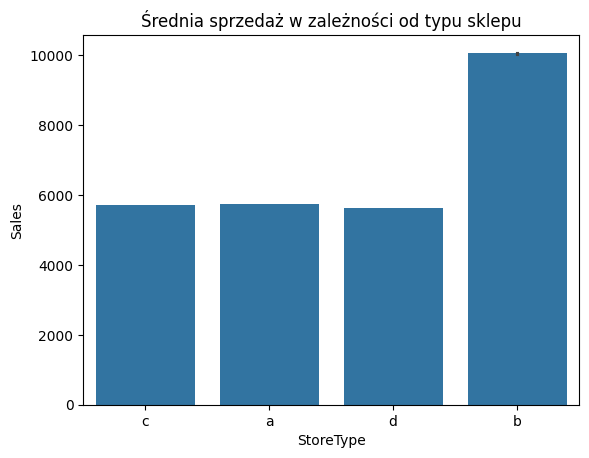

In [13]:
sns.barplot(x='StoreType', y='Sales', data=merged_data)
plt.title('Średnia sprzedaż w zależności od typu sklepu')
plt.show()
